# Simple DFT based seizure anticipation classifier

In [83]:
import numpy as np
import pandas as pd
import scipy.io
import os
#import mne
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [ ]:
# Import Clinical Szr Onset Times
sub='NA'
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/CLINICIAN_ONSET_TIMES'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinical_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

In [4]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0


In [5]:
def clin_onset_tpt(szr_name, onset_df):
    import re
    name_splt=szr_name.split('_')
    day=int(name_splt[1][1:])
    szr=int(re.findall('[0-9]+',name_splt[2])[0])
    print('Getting clinical onset time for %s: Day %d, Szr %d' % (name_splt[0],day,szr))

    # temp_df=onset_df[onset_df['DAY']==day and onset_df['SZR#']==2]
    day_ids=onset_df[onset_df['DAY']==day].index 
    szr_ids=onset_df[onset_df['SZR#']==szr].index 
    use_id=day_ids.intersection(szr_ids)
    onset_tpt=onset_df['ONSET_TPT'].iloc[use_id].values[0]
    return onset_tpt

szr_name='NA_d1_sz2.mat'
onset_tpt=clin_onset_tpt(szr_name, onset_df)

Getting clinical onset time for NA: Day 1, Szr 2


In [67]:
# Import Data
szr_name='NA_d1_sz2.mat'
if sys.platform=='linux':
    ieeg_root='/home/dgroppe/TWH_EEG'
else:
    ieeg_root='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'
ieeg_dir=os.path.join(ieeg_root,sub,'Data')
ieeg_fname=os.path.join(ieeg_dir,szr_name)
print('Loading %s' % ieeg_fname)
mat=scipy.io.loadmat(ieeg_fname)
Sf=mat['Sf'][0]
ieeg=mat['matrix_bi']
ieeg=ieeg.T
n_chan, n_tpt=ieeg.shape
tpts_sec=np.arange(0,n_tpt)/Sf
tpts_sec=tpts_sec.T
# Import Channel Labels
chan_fname=os.path.join(ieeg_root,sub,
                        sub+'_channel_info.csv')
print('Loading %s' % chan_fname)
chan_labels_df=pd.read_csv(chan_fname,names=['label'])
# Convert to list and remove redundant electrode stem for second electrode in each bipolar pair
chan_labels=ief.clean_labels(list(chan_labels_df['label']))

onset_chan_id=12; #RHD1-2
contralat_chan_id=0; #LHD1-2

Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/Data/NA_d1_sz2.mat
Loading /Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/NA/NA_channel_info.csv


In [7]:
# List channel names
for ct, chan_str in enumerate(chan_labels):
    print('%d: %s' % (ct,chan_str))

0: LHD1-2
1: LHD2-3
2: LHD3-4
3: LAT1-2
4: LAT2-3
5: LAT3-4
6: LMT1-2
7: LMT2-3
8: LMT3-4
9: LPT1-2
10: LPT2-3
11: LPT3-4
12: RHD1-2
13: RHD2-3
14: RHD3-4
15: RAT1-2
16: RAT2-3
17: RAT3-4
18: RMT1-2
19: RMT2-3
20: RMT3-4
21: RSPT1-2
22: RSPT2-3
23: RSPT3-4
24: RSPT4-5
25: RSPT5-6
26: RIPT1-2
27: RIPT2-3
28: RIPT3-4
29: RIPT4-5
30: RIPT5-6


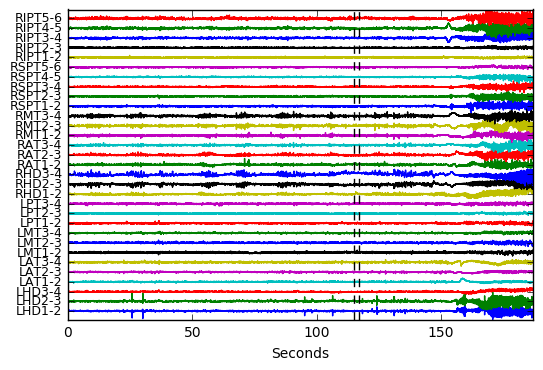

In [8]:
# Plot voltage time series and onset
[h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)

onset_upper_bnd_sec=(onset_tpt/Sf)+1
onset_lower_bnd_sec=(onset_tpt/Sf)-1
ylim=ax.get_ylim()
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')

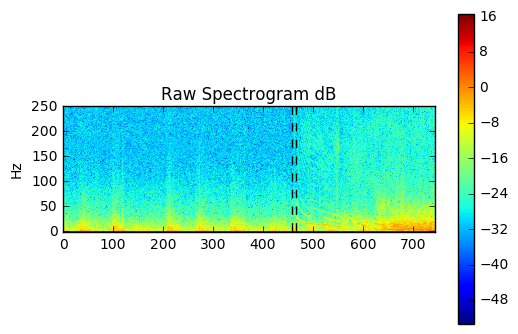

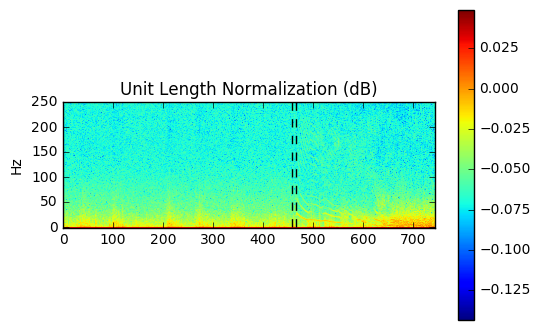

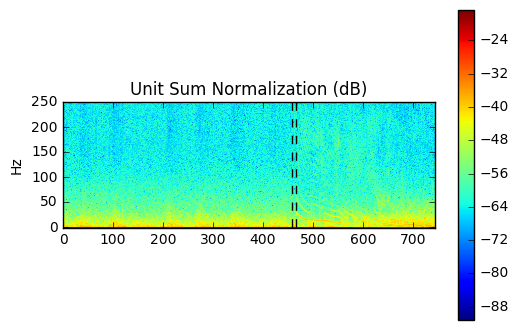

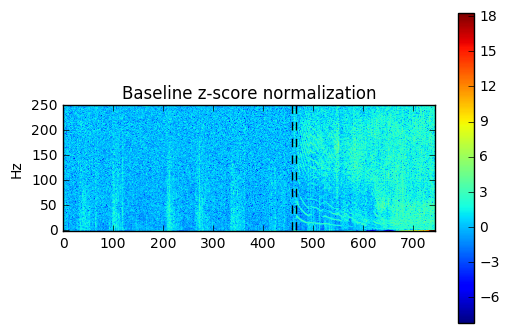

In [119]:
imp.reload(ief) 
# Compute spectrogram for onset channel
#sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,Sf,Sf/4,4,tpts_sec)
sgram, f, sgram_sec=ief.hamming_sgram(ieeg[onset_chan_id,:],Sf,Sf,Sf/4,tpts_sec)
# ief.z_norm(sgram,sgram_sec,onset_tpt)

# Raw Spectrogram (dB)
plt.figure(2)
plt.clf()
plt.imshow(sgram)
onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
plt.title('Raw Spectrogram dB')
plt.colorbar()

# Column normalized spectrogram (column vectors have length 1)
sgram_nrm=preprocessing.normalize(sgram,axis=0)
plt.figure(3)
plt.clf()
plt.imshow(sgram_nrm)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
plt.title('Unit Length Normalization (dB)')
plt.colorbar()

# Column normalized spectrogram (column vectors sum to 1 be dB scaling)
sgram_pos=np.exp(sgram.copy()/10)
sgram_pos=sgram_pos/np.sum(sgram_pos,axis=0)
use_db=True
if use_db:
    sgram_pos=10*np.log(sgram_pos)
plt.figure(4)
plt.clf()
plt.imshow(sgram_pos)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
if use_db:
    plt.title('Unit Sum Normalization (dB)')
else:
    plt.title('Unit Sum Normalization not-dB')
plt.colorbar()

# Baseline z-score normalization
sgram_z=sgram.copy()
ief.z_norm(sgram_z, sgram_sec, onset_lower_bnd_sec)
plt.figure(5)
plt.clf()
plt.imshow(sgram_z)
ylim=plt.ylim()
plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
plt.ylim(ylim)
plt.xlim([0,len(sgram_sec)])
plt.ylabel('Hz')
plt.gca().invert_yaxis()
plt.title('Baseline z-score normalization')
plt.colorbar()

In [116]:
# Define frequency bands
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,Sf[0]*.4)) # High Gamma (this skips 60 Hz DC and accommodates analog acquisition filter, 
# 40% of Sf is max freq you want to examine)
n_band=len(bands)
band_labels=['Delta','Theta','Alpha','Beta','Gamma','High Gamma']

In [104]:
# Average dB power by frequency band 
#imp.reload(ief) 
[db_pwr, sgram_sec]=ief.bp_pwr(ieeg,Sf,Sf,int(Sf/4),4,tpts_sec,bands,taper='hamming')
# z-score spectral power based on pre-onset stats
for chan_loop in range(n_chan):
    ief.z_norm(db_pwr[chan_loop,:,:], sgram_sec, onset_lower_bnd_sec)

(31, 6, 744)


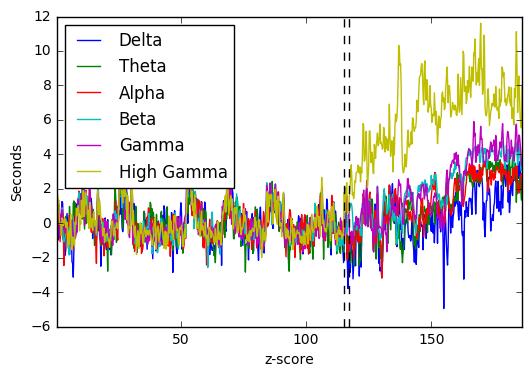

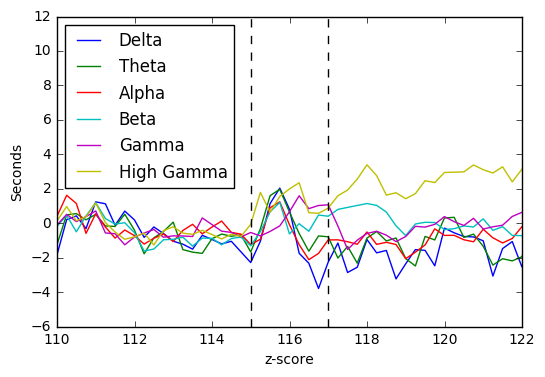

In [105]:
# Plot bandlimited time series
print(db_pwr.shape)

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(sgram_sec,db_pwr[onset_chan_id,:,:].T)
onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([sgram_sec[onset_sgram_tpt_upper], sgram_sec[onset_sgram_tpt_upper]],ylim,'k--')
plt.plot([sgram_sec[onset_sgram_tpt_lower], sgram_sec[onset_sgram_tpt_lower]],ylim,'k--')
plt.ylim(ylim)
plt.xlim([sgram_sec[0], sgram_sec[-1]])
plt.legend(handles,band_labels,loc='upper left')
plt.ylabel('Seconds')
plt.xlabel('z-score')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
_=plt.plot(sgram_sec,db_pwr[onset_chan_id,:,:].T)
onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
plt.plot([sgram_sec[onset_sgram_tpt_upper], sgram_sec[onset_sgram_tpt_upper]],ylim,'k--')
plt.plot([sgram_sec[onset_sgram_tpt_lower], sgram_sec[onset_sgram_tpt_lower]],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.ylabel('Seconds')
plt.xlabel('z-score')

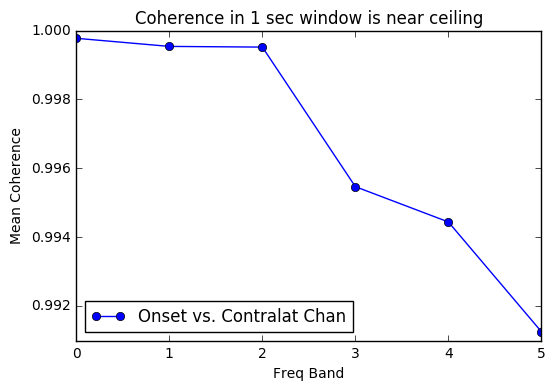

In [188]:
# Avg coherence by freq band
imp.reload(ief) 
[bp_coh, bp_coh_sec]=ief.bp_coh(ieeg[contralat_chan_id,:],ieeg[onset_chan_id,:],
                               Sf,Sf,int(Sf/4),tpts_sec,bands)
# old Multitaper code
# [bp_coh, bp_coh_sec]=ief.bp_coh_mt(ieeg[contralat_chan_id,:],ieeg[onset_chan_id,:],
#                                Sf,Sf,int(Sf/4),4,tpts_sec,bands)

# z-score coherence based on pre-onset stats
#ief.z_norm(bp_coh, bp_coh_sec, onset_lower_bnd_sec)

# convert coherence values to percentiles based on pre-onset stats
onset_bp_coh_tpt_upper=dg.find_nearest(bp_coh_sec,onset_upper_bnd_sec)
bp_ptile=np.zeros((n_band,onset_bp_coh_tpt_upper))
for band_loop in range(n_band):
    bp_ptile[band_loop,:]=[stats.percentileofscore(bp_coh[band_loop,:onset_bp_coh_tpt_upper],
                                      a, 'rank') for a in bp_coh[band_loop,:onset_bp_coh_tpt_upper]]

mn_coh=np.mean(bp_coh,axis=1)
plt.plot(mn_coh,'-o',label='Onset vs. Contralat Chan')
plt.xlabel('Freq Band')
plt.ylabel('Mean Coherence')
plt.legend(loc='lower left')
plt.title('Coherence in 1 sec window is near ceiling')

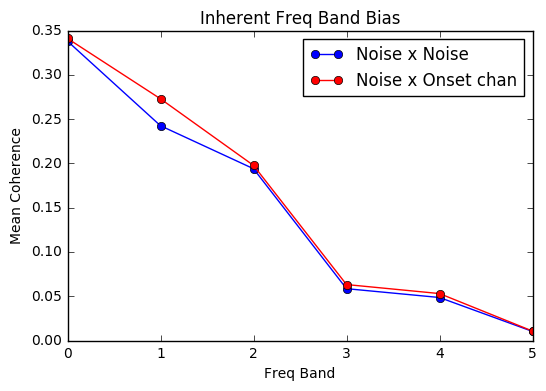

In [182]:
# Compute Mean Coherence between Gaussian noise of equal length to actual data
bp_coh3, _=ief.bp_coh(np.random.randn(n_tpt),np.random.randn(n_tpt),
                               Sf,Sf,int(Sf/4),tpts_sec,bands)
mn_coh3=np.mean(bp_coh3,axis=1)

bp_coh2, _=ief.bp_coh(ieeg[onset_chan_id,:],np.random.randn(n_tpt),
                               Sf,Sf,int(Sf/4),tpts_sec,bands)
mn_coh2=np.mean(bp_coh2,axis=1)

plt.plot(mn_coh3,'-o',label='Noise x Noise')
plt.plot(mn_coh2,'-or',label='Noise x Onset chan')
plt.xlabel('Freq Band')
plt.ylabel('Mean Coherence')
plt.legend()
plt.title('Inherent Freq Band Bias')

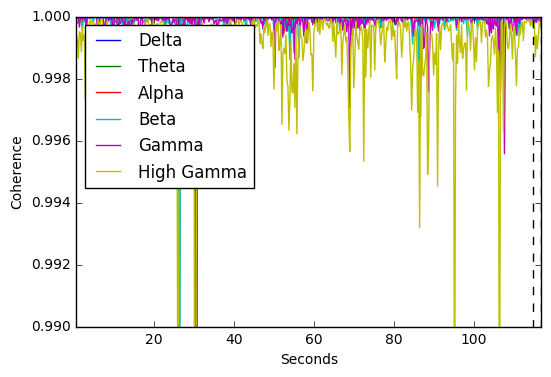

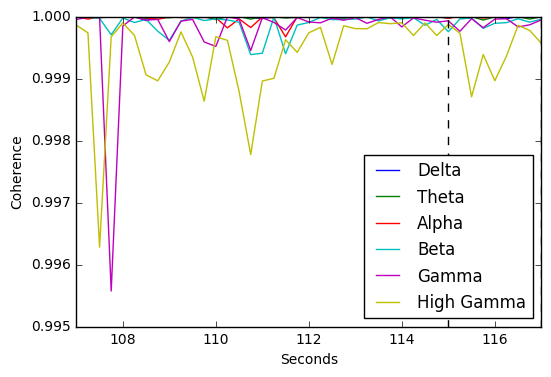

In [157]:
# Plot bandlimited coherence time series 

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim([.99, 1])
plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Coherence')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim([.995, 1])
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='lower right')
plt.xlabel('Seconds')
plt.ylabel('Coherence')


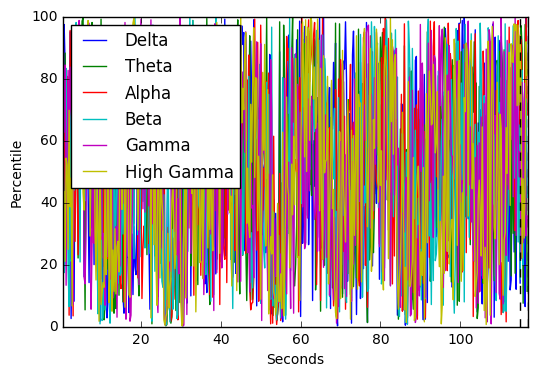

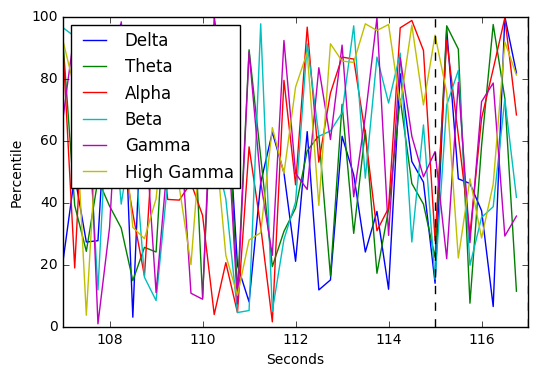

In [151]:
# Plot bandlimited coherence time series with Percentile Normalization

#Plot power across all frequences at onset channel and all time points
plt.figure(1)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Percentile')

# Plot just a few seconds around the onset window
plt.figure(2)
plt.clf
handles=plt.plot(bp_coh_sec[:onset_bp_coh_tpt_upper],bp_ptile.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
ylim=plt.ylim()
plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
plt.ylim(ylim)
plt.xlim([onset_upper_bnd_sec-10, onset_upper_bnd_sec])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('Percentile')


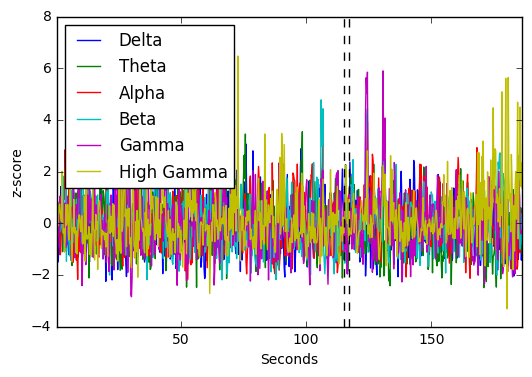

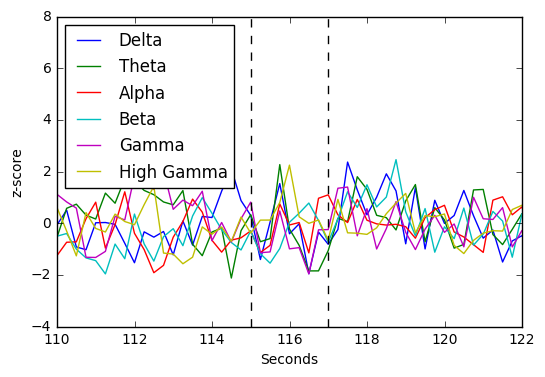

In [97]:
# Plot avg coherence by freq band
plt.figure(13)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
onset_bp_coh_tpt_upper=dg.find_nearest(bp_coh_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([bp_coh_sec[onset_sgram_tpt_upper], bp_coh_sec[onset_sgram_tpt_upper]],ylim,'k--')
plt.plot([bp_coh_sec[onset_sgram_tpt_lower], bp_coh_sec[onset_sgram_tpt_lower]],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], bp_coh_sec[-1]])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z-score')

plt.figure(14)
plt.clf
handles=plt.plot(bp_coh_sec,bp_coh.T)
onset_bp_coh_tpt_lower=dg.find_nearest(bp_coh_sec,onset_lower_bnd_sec)
onset_bp_coh_tpt_upper=dg.find_nearest(bp_coh_sec,onset_upper_bnd_sec)
ylim=plt.ylim()
plt.plot([bp_coh_sec[onset_sgram_tpt_upper], bp_coh_sec[onset_sgram_tpt_upper]],ylim,'k--')
plt.plot([bp_coh_sec[onset_sgram_tpt_lower], bp_coh_sec[onset_sgram_tpt_lower]],ylim,'k--')
plt.ylim(ylim)
plt.xlim([bp_coh_sec[0], bp_coh_sec[-1]])
plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+5])
plt.legend(handles,band_labels,loc='upper left')
plt.xlabel('Seconds')
plt.ylabel('z-score')